# Map to TOD, back to Map

In [62]:
import healpy as hp
import numpy as np
import pysm3.units as u
import pysm3 as pysm
import matplotlib.pyplot as plt

1. Map simulation

In [63]:
## Define resolution

Nside = 128
lmax = 3*Nside-1

In [64]:
##Create a polarized CMB map
sky = pysm.Sky(nside=Nside, preset_strings=["d1","s1"])

In [65]:
sky.components

In [66]:
map_100GHz = sky.get_emission(100*u.GHz)
map_100GHz = map_100GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(100*u.GHz))

In [67]:
print(map_100GHz.shape)

(3, 196608)


In [68]:
Npix = map_100GHz[0].shape[0]
print(type(Npix))

<class 'int'>


In [69]:
total_pix_arr = np.arange(0,Npix)
print(total_pix_arr.shape)

(196608,)


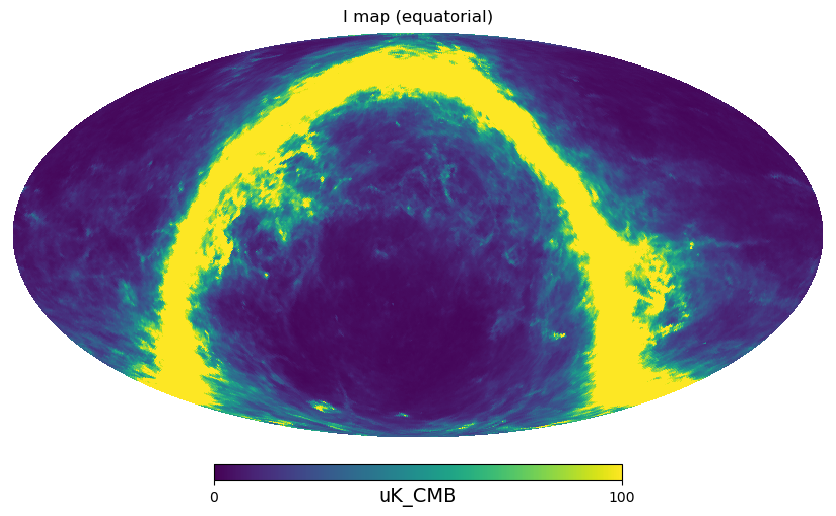

In [70]:
rGC = hp.rotator.Rotator(coord=['G','C'])  # Transforms galactic to equatorial coordinates
map_100GHz_GC = np.array([rGC.rotate_map_pixel(map) for map in map_100GHz])
hp.mollview(map_100GHz_GC[0], min=0, max=1e2, title="I map (equatorial)", unit=map_100GHz.unit)

In [71]:
print(map_100GHz_GC.shape)

(3, 196608)


2. Define instrument

2 pairs of detectors. Assume the two pairs stare at the same pixel.

In [72]:
## Range of focal plane 

detectors = np.pi* np.arange(0,4)/4
print(detectors)

[0.         0.78539816 1.57079633 2.35619449]


3. Define scanning strategy

Angles are directly defined in equatorial coordinates since we observe from the South Pole.

Store signal and azimuth as a function of time.

In [73]:
##define elevation, scan period
Ntime = 10000
el = 45
th_obs =180-el
th_obs_arr = th_obs*np.ones(Ntime)
Tscan = 1000 
t_arr = np.linspace(0,Tscan,Ntime)
T0 = np.zeros(Ntime)

In [74]:
print(th_obs_arr)

[135. 135. 135. ... 135. 135. 135.]


In [75]:
az_0 = np.zeros(Ntime)

In [76]:
Day_sid = 23 * 3600+ 56*60

In [77]:
## define azimuth scan 
velscan = 10
def az(time,period):
    return(np.cos(velscan*time*2*np.pi/period))

In [78]:
## define sky drift

velsky = 100.0 
def sky_drift(time):
    return (time*velsky/Day_sid)

In [79]:
print(el)
print(Tscan)
print(t_arr.shape)

45
1000
(10000,)


In [80]:
def phi(az0,Tinit,period,time):
    return (az(time,period)+az0+sky_drift(time-Tinit))

In [81]:
phi_arr = phi(az_0,T0,Tscan,t_arr)

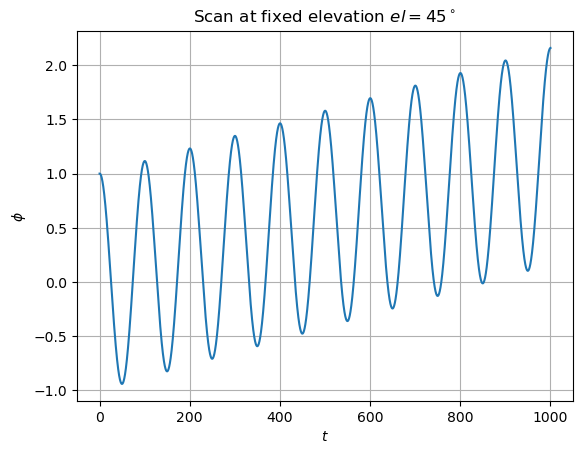

In [82]:
plt.plot(t_arr,phi_arr)
plt.xlabel(r'$t$')
plt.ylabel(r'$\phi$')
plt.title('Scan at fixed elevation $el = 45^\circ$')
plt.grid()
plt.show()

Regarder la stratégie de scan

4. Reconstruct timestream data 

In [83]:
pix_arr =hp.ang2pix(nside=Nside,theta=th_obs_arr*np.pi/180,phi = phi_arr)

In [84]:
print(pix_arr)

[167644 167644 167644 ... 167733 167733 167733]


In [85]:
TOD_IQU = np.array([m[pix_arr] for m in map_100GHz_GC]) ## Select pixels in maps

In [86]:
TOD_IQU.shape

(3, 10000)

In [87]:
TOD_dets = np.zeros((4,Ntime))
for i in range(4):
    TOD_dets[i] = TOD_IQU[0]+ np.cos(2*detectors[i])*TOD_IQU[1]+ np.sin(2*detectors[i])*TOD_IQU[2]
print(TOD_dets.shape)

(4, 10000)


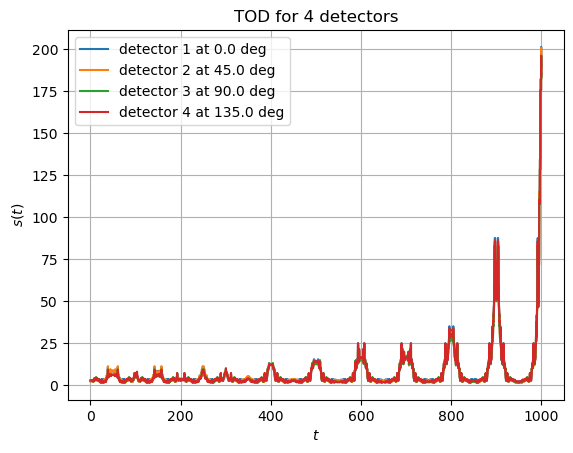

In [88]:
plt.plot(t_arr,TOD_dets[0], label = 'detector 1 at '+str((detectors[0]*u.rad).to(u.deg)))
plt.plot(t_arr,TOD_dets[1], label = 'detector 2 at '+str((detectors[1]*u.rad).to(u.deg)))
plt.plot(t_arr,TOD_dets[2], label = 'detector 3 at '+str((detectors[2]*u.rad).to(u.deg)))
plt.plot(t_arr,TOD_dets[3], label = 'detector 4 at '+str((detectors[3]*u.rad).to(u.deg)))
plt.xlabel(r'$t$')
plt.ylabel(r'$s(t)$')
plt.title('TOD for 4 detectors')
# plt.yscale('log')
# plt.xscale('log')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

$s(t) = I+ Q \cos{2\psi_t}+U\sin{2\psi_t}$ hence : 
\begin{equation}
    \begin{cases}
        s_1 &= I+Q\\
        s_2 &= I+U\\
        s_3 &= I-Q\\
        s_4 &= I-U\\
    \end{cases}
\end{equation}

5. Reconstruct map

In [89]:
#First count the number of hits per pixel

pix_count = np.zeros(Npix)
for i in range(Ntime):
    pix_count[pix_arr[i]]+=1

In [90]:
hit_mask = np.array(np.where(pix_count<=0))[0]
mask = np.ones(pix_count.shape,dtype = np.float64)
mask[hit_mask] = 0

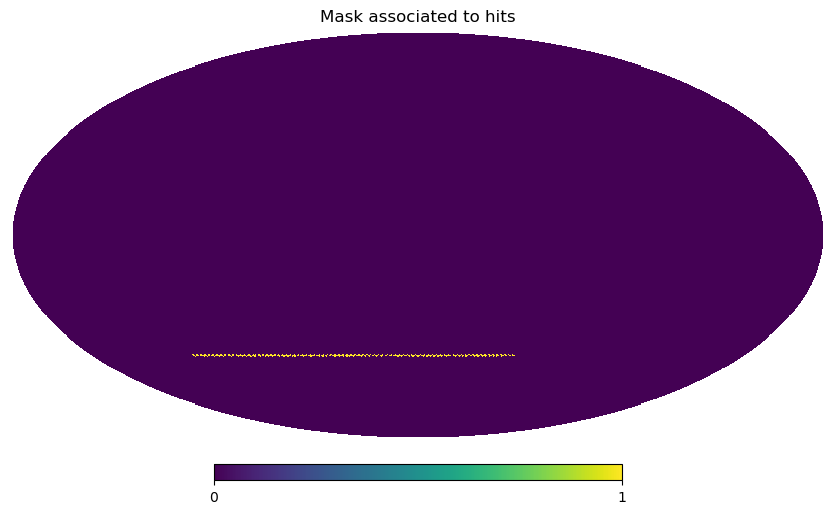

In [91]:
hp.mollview(mask, title = 'Mask associated to hits')

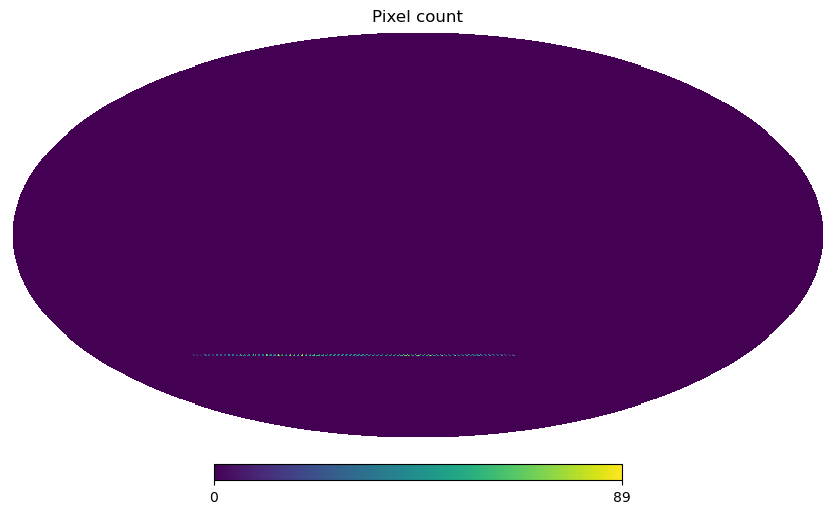

In [92]:
hp.mollview(pix_count,title = 'Pixel count')

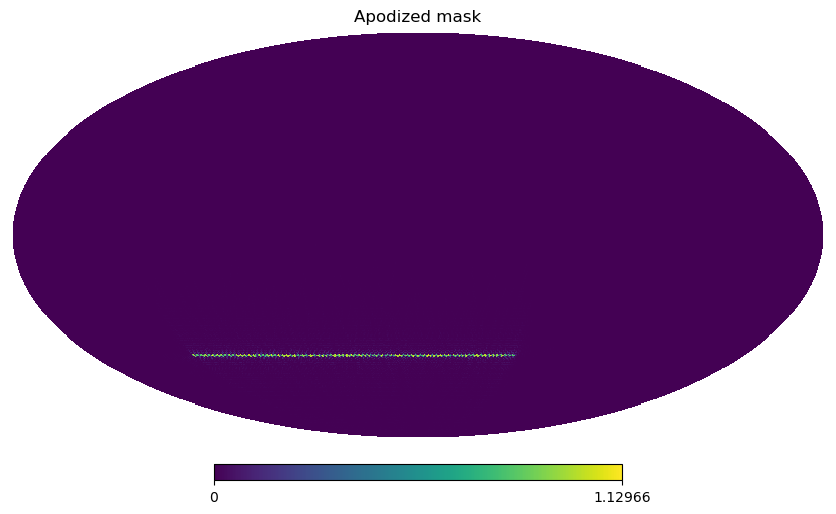

In [93]:
apodized_mask = np.clip(hp.smoothing(mask, fwhm=np.radians(0.1)), 0, None)
hp.mollview(apodized_mask, title = 'Apodized mask')

In [94]:
#Set of visited pixels
pix_set = set(pix_arr)
pixset_arr = np.array([list(pix_set)])[0]
print(pixset_arr.shape)

(351,)


We need to recombine the TODs to retrieve the Stokes parameters :

In [95]:
TOD_I = np.mean(TOD_dets, axis=0)
TOD_I.shape

(10000,)

In [96]:
print(TOD_I-TOD_IQU[0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.84217094e-14
 -2.84217094e-14 -2.84217094e-14]


In [97]:
TOD_Q = (TOD_dets[0]-TOD_dets[2])/2
print(TOD_Q-TOD_IQU[1])

[-1.66533454e-16 -1.66533454e-16 -1.66533454e-16 ...  3.99680289e-15
  3.99680289e-15  3.99680289e-15]


In [98]:
TOD_U = (TOD_dets[1]-TOD_dets[3])/2
print(TOD_U-TOD_IQU[2])

[-1.66533454e-16 -1.66533454e-16 -1.66533454e-16 ... -8.88178420e-15
 -8.88178420e-15 -8.88178420e-15]


In [99]:
def mapmaking(TOD,hit_pix,pixelcount, pixel_arr):
    reconstructed_map = np.zeros(Npix)
    scantime = len(TOD)
    for i in range(scantime):
        reconstructed_map[pixel_arr[i]]+= TOD[i]
    for pix in hit_pix:
        reconstructed_map[pix]/= pixelcount[pix]
    return(reconstructed_map)


In [100]:
pix_count.shape

(196608,)

In [101]:
pix_arr[0]

167644

In [102]:
retmap_I = mapmaking(TOD = TOD_I, hit_pix=pixset_arr,pixelcount = pix_count,pixel_arr=pix_arr)
retmap_Q = mapmaking(TOD = TOD_Q, hit_pix=pixset_arr,pixelcount = pix_count,pixel_arr=pix_arr)
retmap_U = mapmaking(TOD = TOD_U, hit_pix=pixset_arr,pixelcount = pix_count,pixel_arr=pix_arr)

In [103]:
retmap_IQU = np.array([retmap_I,retmap_Q,retmap_U])
retmap_IQU.shape

(3, 196608)

In [104]:
#retmap_IQU[:,hit_mask] = hp.UNSEEN

In [105]:
hit_mask

array([     0,      1,      2, ..., 196605, 196606, 196607])

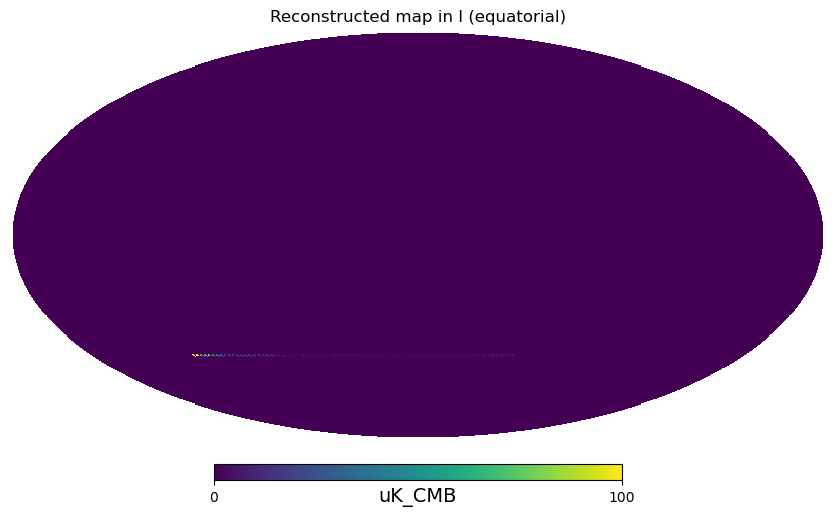

In [106]:
hp.mollview(retmap_I, min=0, max=1e2, title="Reconstructed map in I (equatorial)", unit=map_100GHz.unit)

In [107]:
masked_map = np.zeros((3,Npix))
masked_map[:,pixset_arr] = map_100GHz_GC[:,pixset_arr]

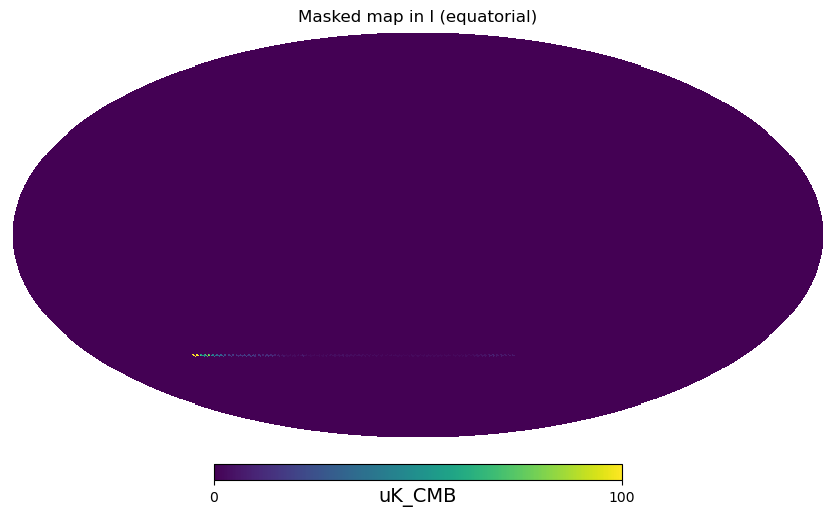

In [108]:
hp.mollview(masked_map[0], min=0, max=1e2, title="Masked map in I (equatorial)", unit=map_100GHz.unit)

Compute the residual map : find zero up to numerical errors.

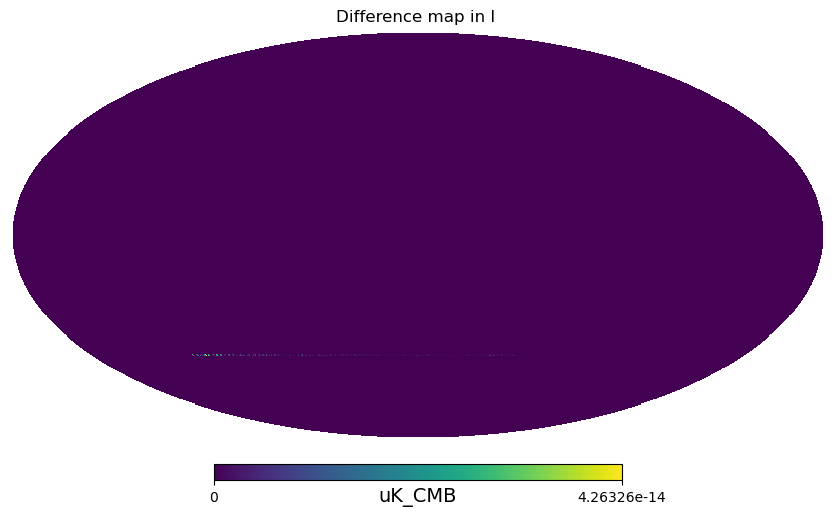

In [109]:
diff_map = np.abs(retmap_IQU-masked_map)

hp.mollview(diff_map[0],  title="Difference map in I ", unit=map_100GHz.unit)

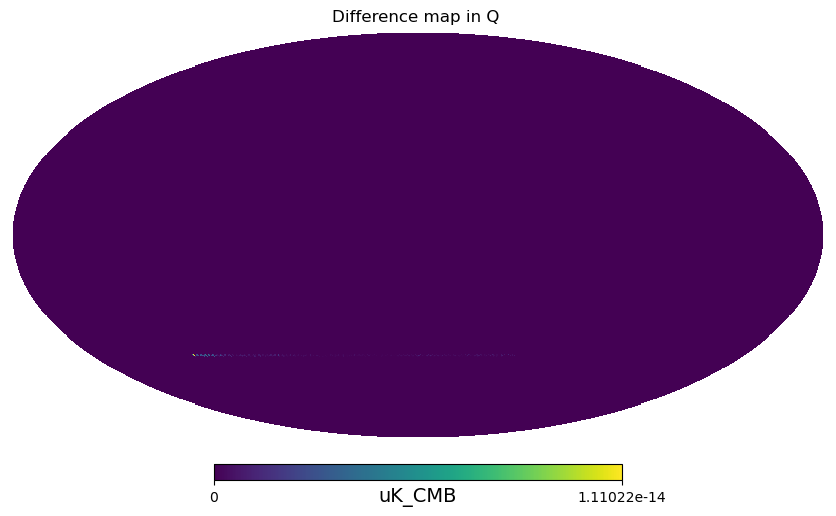

In [110]:
hp.mollview(diff_map[1],  title="Difference map in Q ", unit=map_100GHz.unit)

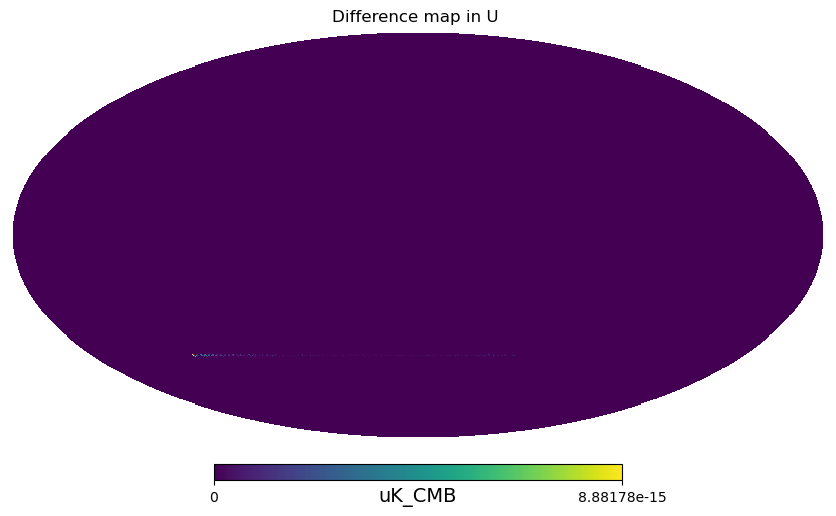

In [111]:
hp.mollview(diff_map[2],  title="Difference map in U ", unit=map_100GHz.unit)